### 生成数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文显示,用来画图的
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

#根据要求封装生成数据的函数
def generate_dataset(means, cov, priors, total_samples=1200, seed=42):
    np.random.seed(seed)
    n_classes = len(means)
    
    # 根据先验概率计算每个类别的样本数
    samples_per_class = [int(total_samples * p) for p in priors]
    # 调整最后一个类别以确保总数正确
    samples_per_class[-1] = total_samples - sum(samples_per_class[:-1])
    
    X = []
    y = []
    
    for i in range(n_classes):
        # 生成多元高斯分布样本
        samples = np.random.multivariate_normal(
            means[i], cov, samples_per_class[i]
        )
        X.append(samples)
        y.append(np.ones(samples_per_class[i]) * i)
    
    X = np.vstack(X)
    y = np.hstack(y).astype(int)
    
    # 打乱数据
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    
    return X, y, samples_per_class

# 设置参数
means = [
    np.array([1, 2]),
    np.array([3, 5]),
    np.array([6, 3]),
    np.array([4, 7])
]
cov = 1.5 * np.eye(2)

# 三种先验概率设置
priors_A = [0.25, 0.25, 0.25, 0.25]  # 均衡
priors_B = [0.5, 0.2, 0.2, 0.1]      # 偏斜1
priors_C = [0.1, 0.1, 0.3, 0.5]      # 偏斜2

# 生成数据集
X_A, y_A, counts_A = generate_dataset(means, cov, priors_A, seed=42)
X_B, y_B, counts_B = generate_dataset(means, cov, priors_B, seed=42)
X_C, y_C, counts_C = generate_dataset(means, cov, priors_C, seed=42)

print("数据集A样本分布:", counts_A)
print("数据集B样本分布:", counts_B)
print("数据集C样本分布:", counts_C)

数据集A样本分布: [300, 300, 300, 300]
数据集B样本分布: [600, 240, 240, 120]
数据集C样本分布: [120, 120, 360, 600]


### 手写参数估计

In [2]:
def estimate_parameters(X,y,n_classes):
    means_est=[]
    covs_est=[]
    priors_est=[]

    n_samples=len(y)
    for i in range(n_classes):
        X_i=X[y==i]
        means_est.append(np.mean(X_i,axis=0))
        covs_est.append(np.cov(X_i.T))
        priors_est.append(len(X_i)/n_samples)

    return means_est, covs_est, priors_est

def multivariate_gaussian_pdf(x, mean, cov):
    """
    计算多元高斯分布的概率密度
    """
    d = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    
    diff = x - mean
    exponent = -0.5 * np.dot(np.dot(diff, inv_cov), diff)
    
    normalization = 1.0 / (np.sqrt((2 * np.pi) ** d * det_cov))
    
    return normalization * np.exp(exponent)


def likelihood_ratio_classifier(X_test, means, covs):
    """
    似然率测试规则分类器（不考虑先验概率）
    """
    n_samples = len(X_test)
    n_classes = len(means)
    
    likelihoods = np.zeros((n_samples, n_classes))
    
    for i in range(n_samples):
        for c in range(n_classes):
            likelihoods[i, c] = multivariate_gaussian_pdf(
                X_test[i], means[c], covs[c]
            )
    
    predictions = np.argmax(likelihoods, axis=1)
    return predictions


def map_classifier(X_test, means, covs, priors):
    """
    最大后验概率（MAP）规则分类器
    """
    n_samples = len(X_test)
    n_classes = len(means)
    
    posteriors = np.zeros((n_samples, n_classes))
    
    for i in range(n_samples):
        for c in range(n_classes):
            likelihood = multivariate_gaussian_pdf(
                X_test[i], means[c], covs[c]
            )
            posteriors[i, c] = likelihood * priors[c]
    
    predictions = np.argmax(posteriors, axis=1)
    return predictions


def compute_confusion_matrix(y_true, y_pred, n_classes):
    """
    计算混淆矩阵
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm


def compute_metrics(y_true, y_pred, n_classes):
    """
    计算分类指标
    """
    cm = compute_confusion_matrix(y_true, y_pred, n_classes)
    
    # 总体准确率
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # 每个类别的准确率
    class_accuracies = []
    for i in range(n_classes):
        if np.sum(cm[i, :]) > 0:
            class_acc = cm[i, i] / np.sum(cm[i, :])
        else:
            class_acc = 0
        class_accuracies.append(class_acc)
    
    return accuracy, class_accuracies, cm



In [3]:
# 测试参数估计分类器
n_classes = 4
datasets = [
    ("A", X_A, y_A, priors_A),
    ("B", X_B, y_B, priors_B),
    ("C", X_C, y_C, priors_C)
]

print("\n========== 参数估计分类器结果 ==========")
for name, X, y, priors_true in datasets:
    # 估计参数
    means_est, covs_est, priors_est = estimate_parameters(X, y, n_classes)
    
    # 似然率测试
    y_pred_lr = likelihood_ratio_classifier(X, means_est, covs_est)
    acc_lr, class_acc_lr, cm_lr = compute_metrics(y, y_pred_lr, n_classes)
    
    # MAP规则
    y_pred_map = map_classifier(X, means_est, covs_est, priors_est)
    acc_map, class_acc_map, cm_map = compute_metrics(y, y_pred_map, n_classes)
    
    print(f"\n数据集 {name}:")
    print(f"  似然率测试 - 总体准确率: {acc_lr:.4f}")
    print(f"  似然率测试 - 各类准确率: {[f'{a:.4f}' for a in class_acc_lr]}")
    print(f"  MAP规则 - 总体准确率: {acc_map:.4f}")
    print(f"  MAP规则 - 各类准确率: {[f'{a:.4f}' for a in class_acc_map]}")



========== 参数估计分类器结果 ==========

数据集 A:
  似然率测试 - 总体准确率: 0.8242
  似然率测试 - 各类准确率: ['0.9400', '0.6367', '0.9200', '0.8000']
  MAP规则 - 总体准确率: 0.8242
  MAP规则 - 各类准确率: ['0.9400', '0.6367', '0.9200', '0.8000']

数据集 B:
  似然率测试 - 总体准确率: 0.8600
  似然率测试 - 各类准确率: ['0.9217', '0.6708', '0.9125', '0.8250']
  MAP规则 - 总体准确率: 0.8808
  MAP规则 - 各类准确率: ['0.9583', '0.7458', '0.9042', '0.7167']

数据集 C:
  似然率测试 - 总体准确率: 0.8475
  似然率测试 - 各类准确率: ['0.9250', '0.7333', '0.9083', '0.8183']
  MAP规则 - 总体准确率: 0.8917
  MAP规则 - 各类准确率: ['0.9000', '0.4000', '0.9444', '0.9567']


### 核密度估计

In [5]:
def gaussian_kernel(x, xi, h):
    """
    高斯核函数
    """
    d = len(x)
    diff = x - xi
    return (1.0 / (h * np.sqrt(2 * np.pi)) ** d) * \
           np.exp(-0.5 * np.dot(diff, diff) / (h ** 2))


def kernel_density_estimation(x, X_train, h):
    """
    核密度估计
    """
    n = len(X_train)
    density = 0
    for xi in X_train:
        density += gaussian_kernel(x, xi, h)
    return density / n


def kde_classifier_likelihood(X_test, X_train, y_train, n_classes, h):
    """
    基于核密度估计的似然率分类器
    """
    n_samples = len(X_test)
    likelihoods = np.zeros((n_samples, n_classes))
    
    for c in range(n_classes):
        X_c = X_train[y_train == c]
        for i in range(n_samples):
            likelihoods[i, c] = kernel_density_estimation(X_test[i], X_c, h)
    
    predictions = np.argmax(likelihoods, axis=1)
    return predictions


def kde_classifier_map(X_test, X_train, y_train, n_classes, h, priors):
    """
    基于核密度估计的MAP分类器
    """
    n_samples = len(X_test)
    posteriors = np.zeros((n_samples, n_classes))
    
    for c in range(n_classes):
        X_c = X_train[y_train == c]
        for i in range(n_samples):
            likelihood = kernel_density_estimation(X_test[i], X_c, h)
            posteriors[i, c] = likelihood * priors[c]
    
    predictions = np.argmax(posteriors, axis=1)
    return predictions


# 交叉验证寻找最优h
def cross_validate_kde(X, y, n_classes, h_values, priors, n_folds=5):
    """
    k折交叉验证
    """
    n_samples = len(X)
    fold_size = n_samples // n_folds
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    results_lr = {h: [] for h in h_values}
    results_map = {h: [] for h in h_values}
    
    for fold in range(n_folds):
        # 划分训练集和验证集
        val_start = fold * fold_size
        val_end = val_start + fold_size if fold < n_folds - 1 else n_samples
        
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]
        
        for h in h_values:
            # 似然率测试
            y_pred_lr = kde_classifier_likelihood(X_val, X_train, y_train, n_classes, h)
            acc_lr = np.mean(y_pred_lr == y_val)
            results_lr[h].append(acc_lr)
            
            # MAP规则
            y_pred_map = kde_classifier_map(X_val, X_train, y_train, n_classes, h, priors)
            acc_map = np.mean(y_pred_map == y_val)
            results_map[h].append(acc_map)
    
    # 计算平均准确率
    mean_acc_lr = {h: np.mean(results_lr[h]) for h in h_values}
    mean_acc_map = {h: np.mean(results_map[h]) for h in h_values}
    
    return mean_acc_lr, mean_acc_map


In [6]:
print("\n========== 核密度估计结果 ==========")
h_values = [0.1, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0]

for name, X, y, priors_true in datasets:
    priors_est = [np.sum(y == i) / len(y) for i in range(n_classes)]
    
    print(f"\n数据集 {name} - 交叉验证中...")
    mean_acc_lr, mean_acc_map = cross_validate_kde(
        X, y, n_classes, h_values, priors_est, n_folds=5
    )
    
    best_h_lr = max(mean_acc_lr, key=mean_acc_lr.get)
    best_h_map = max(mean_acc_map, key=mean_acc_map.get)
    
    print(f"  似然率测试 - 最优h: {best_h_lr}, 准确率: {mean_acc_lr[best_h_lr]:.4f}")
    print(f"  MAP规则 - 最优h: {best_h_map}, 准确率: {mean_acc_map[best_h_map]:.4f}")



========== 核密度估计结果 ==========

数据集 A - 交叉验证中...
  似然率测试 - 最优h: 0.8, 准确率: 0.8225
  MAP规则 - 最优h: 0.8, 准确率: 0.8225

数据集 B - 交叉验证中...
  似然率测试 - 最优h: 1.5, 准确率: 0.8592
  MAP规则 - 最优h: 0.5, 准确率: 0.8700

数据集 C - 交叉验证中...
  似然率测试 - 最优h: 0.5, 准确率: 0.8400
  MAP规则 - 最优h: 0.8, 准确率: 0.8867


### k-近邻密度估计

In [9]:
import math 
def euclidean_distance(x1, x2):
    """
    计算欧氏距离
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))


def knn_density_estimation(x, X_train, k):
    """
    k-近邻密度估计
    """
    n, d = X_train.shape
    
    # 计算到所有训练样本的距离
    distances = np.array([euclidean_distance(x, xi) for xi in X_train])
    
    # 找到第k个最近邻的距离
    sorted_distances = np.sort(distances)
    r_k = sorted_distances[k - 1]  # 第k个最近邻的距离
    
    # 计算体积（d维球体体积）
    # V_d(r) = π^(d/2) / Γ(d/2 + 1) * r^d
    volume = (np.pi ** (d / 2)) / math.gamma(d / 2 + 1) * (r_k ** d)  # ✅ 正确
    
    # 密度估计
    if volume > 0:
        return k / (n * volume)
    else:
        return 0


def knn_classifier_likelihood(X_test, X_train, y_train, n_classes, k):
    """
    基于k-近邻密度估计的似然率分类器
    """
    n_samples = len(X_test)
    likelihoods = np.zeros((n_samples, n_classes))
    
    for c in range(n_classes):
        X_c = X_train[y_train == c]
        for i in range(n_samples):
            # 确保k不超过该类别的样本数
            k_actual = min(k, len(X_c))
            if k_actual > 0:
                likelihoods[i, c] = knn_density_estimation(X_test[i], X_c, k_actual)
    
    predictions = np.argmax(likelihoods, axis=1)
    return predictions


def knn_classifier_map(X_test, X_train, y_train, n_classes, k, priors):
    """
    基于k-近邻密度估计的MAP分类器
    """
    n_samples = len(X_test)
    posteriors = np.zeros((n_samples, n_classes))
    
    for c in range(n_classes):
        X_c = X_train[y_train == c]
        for i in range(n_samples):
            k_actual = min(k, len(X_c))
            if k_actual > 0:
                likelihood = knn_density_estimation(X_test[i], X_c, k_actual)
                posteriors[i, c] = likelihood * priors[c]
    
    predictions = np.argmax(posteriors, axis=1)
    return predictions

In [10]:
print("\n========== k-近邻密度估计结果 ==========")
k_values = [1, 3, 5, 8, 10]

for name, X, y, priors_true in datasets:
    priors_est = [np.sum(y == i) / len(y) for i in range(n_classes)]
    
    print(f"\n数据集 {name}:")
    for k in k_values:
        y_pred_lr = knn_classifier_likelihood(X, X, y, n_classes, k)
        acc_lr = np.mean(y_pred_lr == y)
        
        y_pred_map = knn_classifier_map(X, X, y, n_classes, k, priors_est)
        acc_map = np.mean(y_pred_map == y)
        
        print(f"  k={k}: 似然率={acc_lr:.4f}, MAP={acc_map:.4f}")



========== k-近邻密度估计结果 ==========

数据集 A:
  k=1: 似然率=0.0000, MAP=0.0000
  k=3: 似然率=0.8508, MAP=0.8508
  k=5: 似然率=0.8417, MAP=0.8417
  k=8: 似然率=0.8350, MAP=0.8350
  k=10: 似然率=0.8325, MAP=0.8325

数据集 B:
  k=1: 似然率=0.0000, MAP=0.0000
  k=3: 似然率=0.8817, MAP=0.9008
  k=5: 似然率=0.8758, MAP=0.8917
  k=8: 似然率=0.8658, MAP=0.8750
  k=10: 似然率=0.8633, MAP=0.8767

数据集 C:
  k=1: 似然率=0.0000, MAP=0.0000
  k=3: 似然率=0.8700, MAP=0.9092
  k=5: 似然率=0.8600, MAP=0.8942
  k=8: 似然率=0.8567, MAP=0.8892
  k=10: 似然率=0.8517, MAP=0.8900


### 实验结果可视化

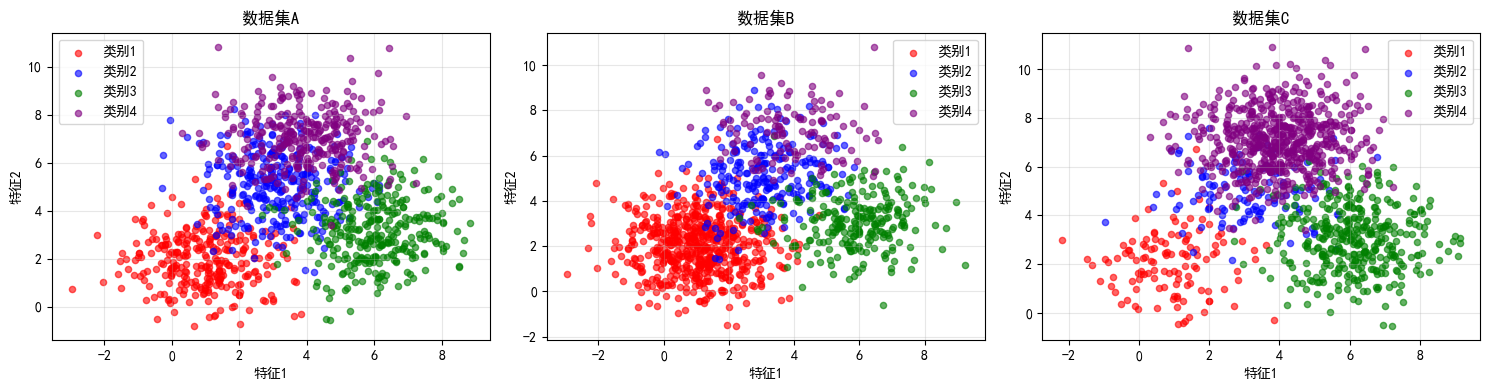

In [11]:
def plot_datasets(datasets_list):
    """
    绘制三个数据集的散点图
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['red', 'blue', 'green', 'purple']
    
    for idx, (name, X, y, _) in enumerate(datasets_list):
        ax = axes[idx]
        for c in range(n_classes):
            mask = y == c
            ax.scatter(X[mask, 0], X[mask, 1], 
                      c=colors[c], label=f'类别{c+1}', 
                      alpha=0.6, s=20)
        ax.set_title(f'数据集{name}')
        ax.set_xlabel('特征1')
        ax.set_ylabel('特征2')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('1.png', dpi=150, bbox_inches='tight')
    plt.show()


# 绘制数据集分布
plot_datasets(datasets)